In [166]:
from importlib import reload
from copy import deepcopy
import os
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision.transforms import ToTensor, RandomCrop, Compose
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.transforms.functional as TF

if not os.path.isdir("./cache"): os.mkdir("cache")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')
from utils_lib import utils

device: cuda


## Net 12

In [81]:
Net12 = nn.Sequential(
    # 3 X 12 X 12
    nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
    # 16 X 12 X 12
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    # 16 X 6 X 6
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 6 *6, 16),
    nn.ReLU(),
    nn.Linear(16, 2)
)
utils.train_12Net(Net12, Epochs = 10, save = False)

9754

In [82]:
# def train_Net(Net, Epochs, mData, path = None, add_softmax = False, print_each = 100):
Net = Net12
Epochs = 4
mData = utils.mData12
path, add_softmax = None, False
print_each = 1

Net.to(device)
opt = optim.Adam(Net.parameters(), lr=  1e-4)
loss_fn = nn.CrossEntropyLoss()
E = Epochs
l_loss, l_acc = {'train':[], 'test':[]}, {'train':[], 'test':[]}
best_model, best_acc = None ,0
dl = mData.DataLoader(typ = 'train', batch_size = 256)
dl_test = mData.DataLoader(typ = 'test', batch_size = 256)

>>>>>>>>>>>>>>>>>>>>>> TRAIN
[0.5427802801132202, 201.0, 132.0, 124.0]
[0.5162914991378784, 204.0, 124.0, 132.0]
[0.5250845551490784, 199.0, 139.0, 117.0]
[0.5529237985610962, 187.0, 132.0, 124.0]
[0.5248029232025146, 200.0, 136.0, 120.0]
[0.5413143038749695, 193.0, 118.0, 138.0]
[0.5240111947059631, 196.0, 128.0, 128.0]
[0.5089012384414673, 203.0, 142.0, 114.0]
[0.5334621667861938, 193.0, 138.0, 118.0]
[0.5413726568222046, 193.0, 119.0, 137.0]
[0.5090231895446777, 200.0, 134.0, 122.0]
[0.5489895343780518, 193.0, 126.0, 130.0]
[0.5307763814926147, 193.0, 138.0, 118.0]
[0.5486952662467957, 190.0, 129.0, 127.0]
[0.512082040309906, 199.0, 128.0, 128.0]
[0.4920792579650879, 219.0, 122.0, 134.0]
[0.5027929544448853, 199.0, 131.0, 125.0]
[0.5098153948783875, 202.0, 136.0, 120.0]
[0.5226142406463623, 197.0, 132.0, 124.0]
[0.49749255180358887, 198.0, 135.0, 121.0]
[0.5095436573028564, 202.0, 134.0, 122.0]
[0.5304718017578125, 197.0, 126.0, 130.0]
[0.5293927192687988, 193.0, 129.0, 127.0]
[0.50

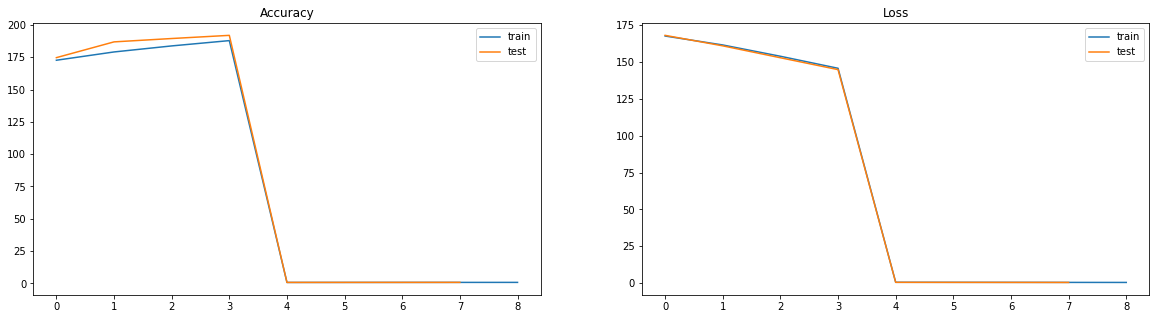

In [89]:
for epoch in range(E):
    
    # train 
    epoch_loss, epoch_acc = 0, 0
    print(">>>>>>>>>>>>>>>>>>>>>> TRAIN")
    for x, y in dl:
        x = TF.resize(x, (12, 12))
        x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
        y_pred = Net(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad() ; loss.backward() ; opt.step()
        with torch.no_grad():
            c_acc = (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).sum()
            epoch_acc += c_acc
        epoch_loss += loss * len(x)
        print(list(map(float, (loss, c_acc, sum(y == 1), sum(y == 0)))))
    l_loss['train'].append(epoch_loss / len(dl.dataset))
    l_acc['train'].append(epoch_acc / len(dl.dataset))
    
    # test
    epoch_loss, epoch_acc = 0, 0
    print(">>>>>>>>>>>>>>>>>>>>>> TEST")
    for x,y in dl_test:
        x = TF.resize(x, (12, 12))
        x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
        with torch.no_grad():
            y_pred = Net(x)
            loss = loss_fn(y_pred, y)
            c_acc = (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).sum()
            epoch_acc += c_acc
            epoch_loss += loss * len(x)
        print(list(map(float, (loss, c_acc, sum(y == 1), sum(y == 0)))))

    # update best model
    l_loss['test'].append(epoch_loss / len(dl_test.dataset))
    l_acc['test'].append(epoch_acc / len(dl_test.dataset))
    if l_acc['test'][-1] > best_acc:
        best_acc = l_acc['test'][-1]
        best_model = deepcopy(Net)
    if epoch % print_each == 0: 
        utils.print_during_train(epoch,l_loss, l_acc)
utils.print_during_train(E-1,l_loss, l_acc)
if path is not None:
    best_model = nn.Sequential(best_model, nn.Softmax(dim = 1))
    torch.save(best_model.cpu(), path)
    print(f">>> model saved to {path}")
utils.plt_loss_acc(l_loss, l_acc)

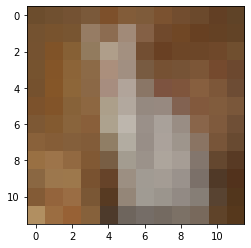

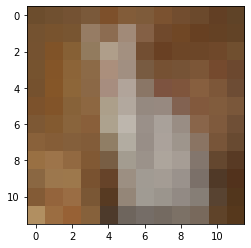

In [106]:
utils.plt_tensor(a)
plt.show()
utils.plt_tensor(b)

In [146]:
dl, dl_test = utils.mData24.DataLoader(256, 'train'), utils.mData24.DataLoader(256, 'test')
tr = set([x.numpy().tobytes() for i ,(x,y) in enumerate(dl.dataset)])
te = set([x.numpy().tobytes() for i, (x,y) in enumerate(dl_test.dataset)])
tri = dict([(x.numpy().tobytes(), i) for i, (x,y) in enumerate(dl.dataset)])
tei = dict([(x.numpy().tobytes(), i) for i, (x,y) in enumerate(dl_test.dataset)])

m = te.intersection(tr)
m = list(m)
len(m)

12

In [147]:
for k in range(len(m)):
    i, j = tri[m[k]], tei[m[k]]
    xtr, ytr = dl.dataset[i]
    xte, yte = dl_test.dataset[j]
    if ytr == 1:
        print(k)

0
1
2
3
4
5
6
7
8
9
10
11


y tr: 1, te: 1


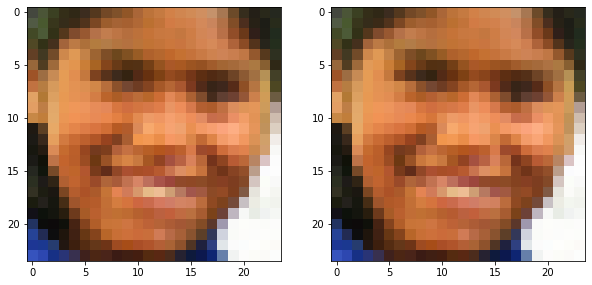

y tr: 1, te: 1


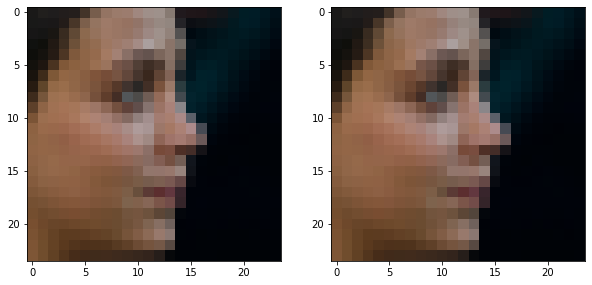

y tr: 1, te: 1


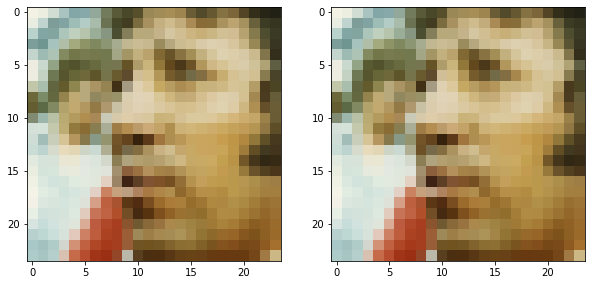

y tr: 1, te: 1


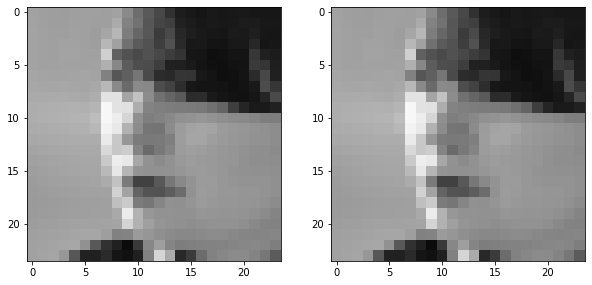

y tr: 1, te: 1


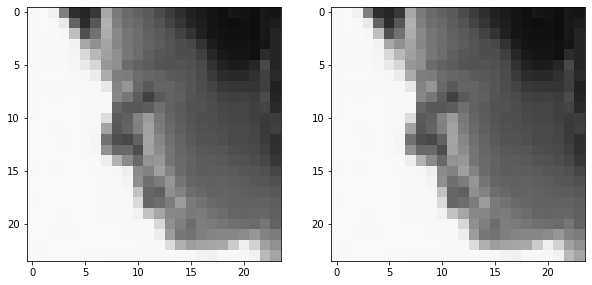

y tr: 1, te: 1


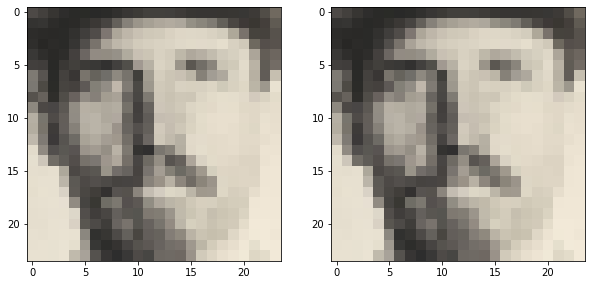

y tr: 1, te: 1


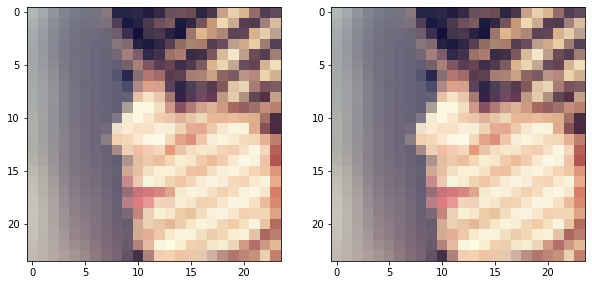

y tr: 1, te: 1


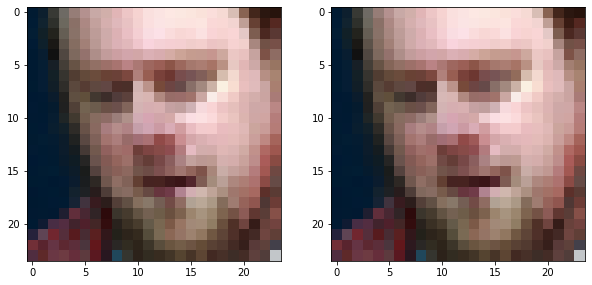

y tr: 1, te: 1


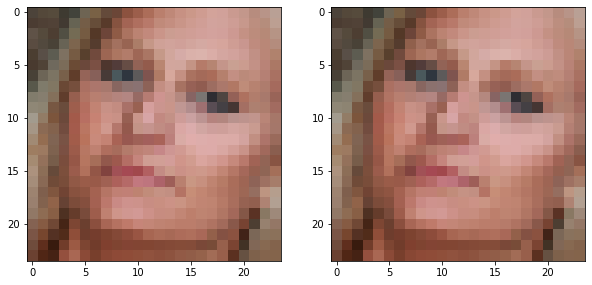

y tr: 1, te: 1


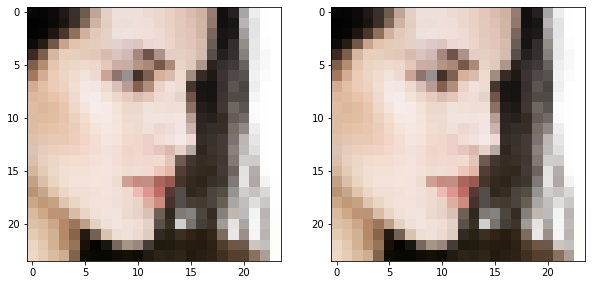

y tr: 1, te: 1


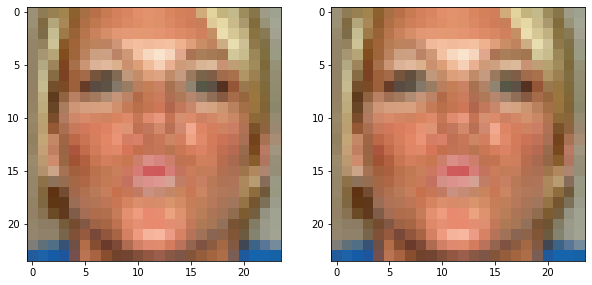

y tr: 1, te: 1


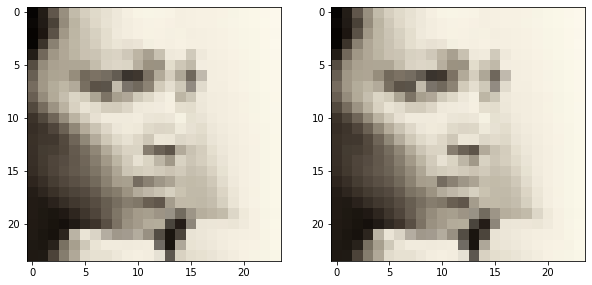

In [148]:
for k in range(12):
    i, j = tri[m[k]], tei[m[k]]
    xtr, ytr = dl.dataset[i]
    xte, yte = dl_test.dataset[j]
    print(f"y tr: {ytr}, te: {yte}")
    plt.figure(figsize = (10, 15))
    plt.subplot(1, 2, 1)
    utils.plt_tensor(xtr) 
    plt.subplot(1,2,2)
    utils.plt_tensor(xte)
    plt.show()

In [164]:
aflw = utils.mData12.noface()
s = set([aflw[i][0].numpy().tobytes() for i in range(len(aflw))])
len(aflw), len(s)

(24385, 24384)

In [165]:
aflw = utils.mData24.noface()
s = set([aflw[i][0].numpy().tobytes() for i in range(len(aflw))])
len(aflw), len(s)

(24385, 24385)

In [112]:
for i in range(len(dl_test.dataset)):
    a = dl_test.dataset[i][0].cpu()
    for j in range(len(dl.dataset)):
        b = dl.dataset[j][0].cpu()
        if torch.sum(abs(a-b)) < 0.001:
            print(f"i = {i} j = {j}")
            break

i = 135 j = 7948


KeyboardInterrupt: 

In [94]:
dl.dataset[1]

(tensor([[[0.2667, 0.2706, 0.3020, 0.3098, 0.3333, 0.3294, 0.2980, 0.2863,
           0.3020, 0.2157, 0.1451, 0.0941],
          [0.2667, 0.2549, 0.2902, 0.2980, 0.3255, 0.3176, 0.2902, 0.2706,
           0.2588, 0.1686, 0.1176, 0.0863],
          [0.2627, 0.2196, 0.2941, 0.3059, 0.3137, 0.2784, 0.2549, 0.2392,
           0.1882, 0.1961, 0.1333, 0.0667],
          [0.2549, 0.1765, 0.2078, 0.2078, 0.2235, 0.2471, 0.2941, 0.3412,
           0.3569, 0.3725, 0.3373, 0.1843],
          [0.1490, 0.2510, 0.2941, 0.3373, 0.3843, 0.4196, 0.4353, 0.4431,
           0.4392, 0.4157, 0.3490, 0.2471],
          [0.3020, 0.3765, 0.4118, 0.4549, 0.4863, 0.4941, 0.5373, 0.5529,
           0.5020, 0.4588, 0.4314, 0.3843],
          [0.4196, 0.5608, 0.6431, 0.5804, 0.5647, 0.5922, 0.6510, 0.6314,
           0.5922, 0.5529, 0.5137, 0.4627],
          [0.4431, 0.6118, 0.7412, 0.7529, 0.6667, 0.6902, 0.6549, 0.6745,
           0.6784, 0.6706, 0.6353, 0.5412],
          [0.4706, 0.5882, 0.6980, 0.7843, 0.749

>>>>>>>>>>>>>>>>>>>>>> TRAIN
[0.6072513461112976, 0.8203125, 145.0, 111.0]
[0.5924445390701294, 0.84375, 119.0, 137.0]
[0.5895280241966248, 0.859375, 116.0, 140.0]
[0.595335841178894, 0.8359375, 131.0, 125.0]
[0.5892637968063354, 0.85546875, 118.0, 138.0]
[0.5921223759651184, 0.8203125, 137.0, 119.0]
[0.5866687297821045, 0.86328125, 125.0, 131.0]
[0.5797222256660461, 0.890625, 123.0, 133.0]
[0.5935158133506775, 0.80859375, 135.0, 121.0]
[0.581136167049408, 0.84765625, 135.0, 121.0]
[0.5850297808647156, 0.87109375, 133.0, 123.0]
[0.5821495056152344, 0.85546875, 126.0, 130.0]
[0.5770615935325623, 0.859375, 129.0, 127.0]
[0.5674930214881897, 0.8828125, 140.0, 116.0]
[0.57414311170578, 0.87890625, 136.0, 120.0]
[0.5747489333152771, 0.83203125, 123.0, 133.0]
[0.5626648664474487, 0.8984375, 122.0, 134.0]
[0.5579037070274353, 0.88671875, 111.0, 145.0]
[0.5601781606674194, 0.859375, 122.0, 134.0]
[0.5750678181648254, 0.83203125, 143.0, 113.0]
[0.5740419030189514, 0.8203125, 144.0, 112.0]
[0.56

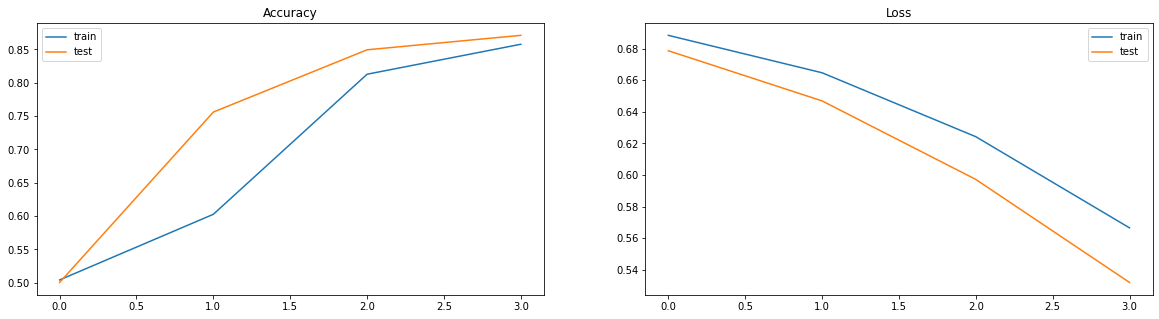

In [77]:
for epoch in range(E):
    epoch_loss, epoch_acc = 0, 0
    # train epoch
    print(">>>>>>>>>>>>>>>>>>>>>> TRAIN")
    for x, y in dl:
        x = TF.resize(x, (12, 12))
        x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
        y_pred = Net(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad() ; loss.backward() ; opt.step()
        with torch.no_grad():
            c_acc = (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).mean()
            epoch_acc += c_acc
        epoch_loss += loss 
        print(list(map(float, (loss, c_acc, sum(y == 1), sum(y == 0)))))
    l_loss['train'].append(epoch_loss / len(dl))
    l_acc['train'].append(epoch_acc / len(dl))
    epoch_loss, epoch_acc = 0, 0
    # test
    print(">>>>>>>>>>>>>>>>>>>>>> TEST")
    for x,y in dl_test:
        x = TF.resize(x, (12, 12))
        x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
        with torch.no_grad():
            y_pred = Net(x)
            loss = loss_fn(y_pred, y)
            c_acc = (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).mean()
            epoch_acc += c_acc
            epoch_loss += loss 
        print(list(map(float, (loss, c_acc, sum(y == 1), sum(y == 0)))))

    # update best model
    l_loss['test'].append(epoch_loss / len(dl_test))
    l_acc['test'].append(epoch_acc / len(dl_test))
    if l_acc['test'][-1] > best_acc:
        best_acc = l_acc['test'][-1]
        best_model = deepcopy(Net)
    if epoch % print_each == 0: 
        utils.print_during_train(epoch,l_loss, l_acc)
utils.print_during_train(E-1,l_loss, l_acc)
if path is not None:
    best_model = nn.Sequential(best_model, nn.Softmax(dim = 1))
    torch.save(best_model.cpu(), path)
    print(f">>> model saved to {path}")
utils.plt_loss_acc(l_loss, l_acc)

### Simple Detector

Modify the 12 Net into FCN:

In [3]:
Net12 = torch.load("cache/models.12Net.best_model")

In [4]:
Net12_layers = list(Net12._modules.values())
#
conv_layer1 = nn.Conv2d(16, 16, kernel_size = 6, stride = 1)
conv_layer1.weight.data = Net12_layers[-3].weight.data.view((16, 16, 6, 6)).detach().clone()
conv_layer1.bias.data = Net12_layers[-3].bias.data.detach().clone()
#
conv_layer2 = nn.Conv2d(16, 2, kernel_size = 1, stride = 1)
conv_layer2.weight.data = Net12_layers[-1].weight.data.view((2, 16, 1, 1)).detach().clone()
conv_layer2.bias.data = Net12_layers[-1].bias.data.detach().clone()

Net12Detector_layers = [deepcopy(l) for l in Net12_layers[:-4]] + [conv_layer1, nn.ReLU(), conv_layer2, nn.Softmax(dim = 1)]
Net12_FCN = nn.Sequential(*Net12Detector_layers)

In [5]:
Net12_FCN = Net12_FCN.to(device)
def detector_model(x = None, path = None, iou_threshold = 0.5, scales = [0.05, 0.08, 0.13, 0.2]):
    if x is None:
        x = Image.open(path)
        x = TF.to_tensor(x)
    x = x.to(device)
    if x.size(0) == 1:
        x = torch.cat([x]*3, dim = 0).type(torch.float32).to(device)
    outs = []
    for scale in scales:
        outs.append(utils.scale_model_nms_pipeline(x, scale, Net12_FCN, iou_threshold = iou_threshold).cpu())
    return torch.cat(outs, 0)


In [ ]:
reload(utils)
scales = [0.05, 0.08, 0.13, 0.2]
ts = (0.1, 0.2, 0.4, 0.6, 0.8, 0.9)
for t in ts:
    name =  f"scales_with_resizes/{'_'.join(map(str, scales))}/{t}"
    utils.gen_fddb_out(lambda x: detector_model(path = x, iou_threshold = t, scales = scales), ellipse = False, name = name)
    cmd = f"./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/scales_with_resizes/{'_'.join(map(str, scales))}/{t}/"
    print(f">>> {cmd}", end = "")
    r = os.system(cmd) 
    print(f", result: {r}")

## 24 Net

In [30]:
reload(utils)

<module 'utils_lib.utils' from '/specific/netapp5_3/ML_courses/students/DL2020/eladb3/eladb3/dl/dl_ex3/utils_lib/utils.py'>

In [162]:
utils.mData24.init(detector_model, neg_mining = True)

Prepare 24Net data...
Finished


In [68]:
Net24 = nn.Sequential(
    # 3 X 24 X 24
    nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 2),
    # 64 X 24 X 24
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    # 64 X 12 X 12
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)

In [69]:
# def train_Net(Net, Epochs, mData, path = None, add_softmax = False, print_each = 100):
Net = Net24
Epochs = 1
mData = utils.mData24
path, add_softmax = None, False
print_each = 1

Net.to(device)
opt = optim.Adam(Net.parameters(), lr=  1e-4)
loss_fn = nn.CrossEntropyLoss()
E = Epochs
l_loss, l_acc = {'train':[], 'test':[]}, {'train':[], 'test':[]}
best_model, best_acc = None ,0
dl = mData.DataLoader(typ = 'train', batch_size = 256)
dl_test = mData.DataLoader(typ = 'test', batch_size = 256)

>>>>>>>>>>>>>>>>>>>>>> TRAIN
[0.1662822663784027, 0.95703125, 149.0, 107.0]
[0.10818243771791458, 0.98046875, 129.0, 127.0]
[0.14868703484535217, 0.94921875, 141.0, 115.0]
[0.15531310439109802, 0.953125, 140.0, 116.0]
[0.1531868875026703, 0.953125, 130.0, 126.0]
[0.09497138857841492, 0.96875, 120.0, 136.0]
[0.1210305392742157, 0.9765625, 120.0, 136.0]
[0.10443170368671417, 0.9765625, 135.0, 121.0]
[0.10306692123413086, 0.9765625, 119.0, 137.0]
[0.13718731701374054, 0.9453125, 125.0, 131.0]
[0.10283743590116501, 0.98046875, 125.0, 131.0]
[0.10814227163791656, 0.96484375, 119.0, 137.0]
[0.0638401210308075, 0.98828125, 121.0, 135.0]
[0.12966136634349823, 0.9453125, 127.0, 129.0]
[0.1177552342414856, 0.96484375, 120.0, 136.0]
[0.12138158082962036, 0.9609375, 127.0, 129.0]
[0.09136687964200974, 0.97265625, 137.0, 119.0]
[0.09842770546674728, 0.96484375, 126.0, 130.0]
[0.09706869721412659, 0.96484375, 123.0, 133.0]
[0.09409959614276886, 0.97265625, 145.0, 111.0]
[0.08580781519412994, 0.97656

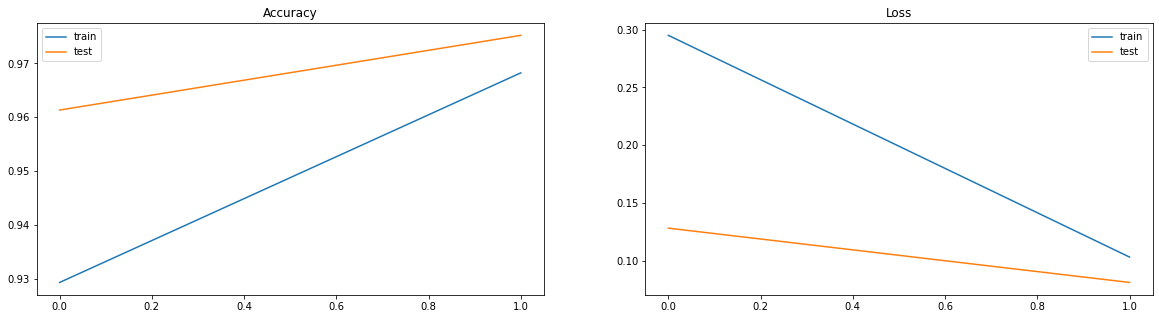

In [71]:
for epoch in range(E):
    epoch_loss, epoch_acc = 0, 0
    # train epoch
    print(">>>>>>>>>>>>>>>>>>>>>> TRAIN")
    for x, y in dl:
        x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
        y_pred = Net(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad() ; loss.backward() ; opt.step()
        with torch.no_grad():
            c_acc = (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).mean()
            epoch_acc += c_acc
        epoch_loss += loss 
        print(list(map(float, (loss, c_acc, sum(y == 1), sum(y == 0)))))
    l_loss['train'].append(epoch_loss / len(dl))
    l_acc['train'].append(epoch_acc / len(dl))
    epoch_loss, epoch_acc = 0, 0
    # test
    print(">>>>>>>>>>>>>>>>>>>>>> TEST")
    for x,y in dl_test:
        x, y = x.to(device), y.view(-1).type(torch.int64).to(device)
        with torch.no_grad():
            y_pred = Net(x)
            loss = loss_fn(y_pred, y)
            c_acc = (y_pred.cpu().argmax(axis=1) == y.cpu()).type(torch.float32).mean()
            epoch_acc += c_acc
            epoch_loss += loss 
        print(list(map(float, (loss, c_acc, sum(y == 1), sum(y == 0)))))

    # update best model
    l_loss['test'].append(epoch_loss / len(dl_test))
    l_acc['test'].append(epoch_acc / len(dl_test))
    if l_acc['test'][-1] > best_acc:
        best_acc = l_acc['test'][-1]
        best_model = deepcopy(Net)
    if epoch % print_each == 0: 
        utils.print_during_train(epoch,l_loss, l_acc)
utils.print_during_train(E-1,l_loss, l_acc)
if path is not None:
    best_model = nn.Sequential(best_model, nn.Softmax(dim = 1))
    torch.save(best_model.cpu(), path)
    print(f">>> model saved to {path}")
utils.plt_loss_acc(l_loss, l_acc)

## Better Detector

In [11]:
reload(utils)

<module 'utils_lib.utils' from '/specific/netapp5_3/ML_courses/students/DL2020/eladb3/eladb3/dl/dl_ex3/utils_lib/utils.py'>

In [34]:
Net24 = torch.load("cache/models.24Net.best_model")

In [35]:
Net24= Net24.to(device)
def detector_model2(x = None, path = None, iou_threshold = 0.5, scales = [0.05, 0.08, 0.13, 0.2]):
    if x is None:
        x = Image.open(path)
        x = TF.to_tensor(x)
    x = x.to(device)
    if x.size(0) == 1:
        x = torch.cat([x]*3, dim = 0).type(torch.float32).to(device)
    out = utils.scale_model_nms_pipeline(x, scales, Net12_FCN, iou_threshold = iou_threshold).cpu() # (N_crops, 5)
    # use 24Net to reduce FP
    with torch.no_grad():
        out_resized = utils.get_resized_crops(x, out, size = 24).to(device) # (N_crops, 3, 24, 24)
        out24 = Net24(out_resized).cpu() #(N_crops, 2)
    
    net24_threshold = 0.5
    return out_resized, out, out24
    net24_probs = out24[:, 1] # face prob
    #out[:, -1] *= net24_probs
    return out
    
        

In [11]:
path = "./data/EX2_data/fddb/images/2002/09/01/big/img_16189.jpg"
r= detector_model2(path = path, iou_threshold = 0.02)
print(r.shape)
# r = list(sorted(r, key=lambda x: -x[-1]))
x = Image.open(path)
utils.plot_with_rec(x, r,limit = 0)

NameError: name 'r' is not defined

In [36]:
path = "./data/EX2_data/fddb/images/2002/09/01/big/img_16189.jpg"
imgs, p12, p24 = detector_model2(path = path)


In [57]:
i = 29

In [55]:
Net24(x[[i]].to(device))

tensor([[0.9980, 0.0020]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [42]:
dl = utils.mData24.DataLoader(typ = 'train', batch_size = 256)
for x, y in dl:
    break

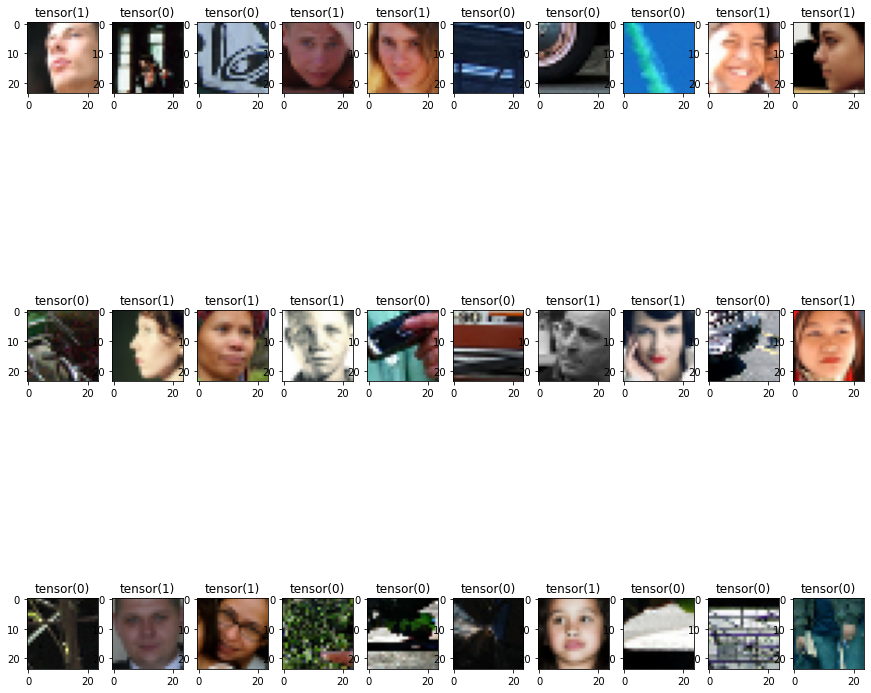

In [51]:
plt.figure(figsize=(15,15))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.title(y[i])
    utils.plt_tensor(x[i])

(tensor([120.0000, 200.0000, 360.0000, 440.0000,   0.9998]),
 tensor([0.0244, 0.9756]))

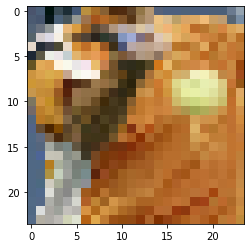

In [38]:
#imgs, p
i = 12
utils.plt_tensor(imgs[i])
p12[i], p24[i]

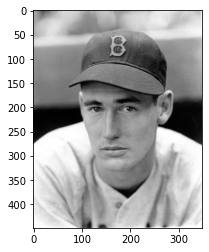

In [28]:
reload(utils)
x = Image.open("./data/EX2_data/fddb/images/2002/07/22/big/img_725.jpg")
# plt.imshow(x)
x = TF.to_tensor(x)
x = torch.cat([x]*3, dim = 0)
utils.plt_tensor(x)

In [745]:
scale = 0.1
r = scale_fcn_boxes(x, scale, Net12_FCN, 0.2)
r.shape

torch.Size([15, 5])

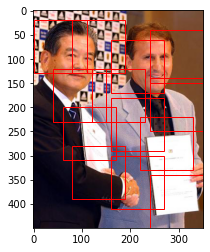

In [746]:
utils.plot_with_rec(x, r,scale =scale, limit = 0.9)

In [725]:
reload(utils)
x = torch.rand((2, 3,450, 377))
out = Net12_FCN(x)

In [256]:
out.shape

torch.Size([2, 2, 220, 184])

In [262]:
utils.nms(out, 0.4)[1, 1, :]

tensor([154.0000,   0.0000, 165.0000,  11.0000,   0.5950])

### FDDB

In [345]:
x._size

(275, 450)

In [346]:
x = TF.to_tensor(x)
x.shape
# x = TF.resize(x, size = (100, 100))

torch.Size([3, 450, 275])

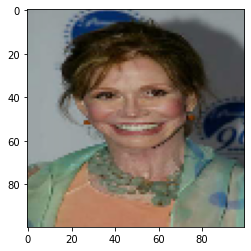

In [330]:
utils.plt_tensor(x)

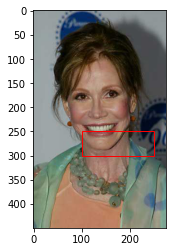

In [378]:

# Display the image
plt.imshow(x)
# Add the patch to the Axes
plt.gca().add_patch(Rectangle((100, 250),150, 50,linewidth=1,edgecolor='r',facecolor='none'))


In [4]:
len(utils.mData.aflw[12])

24385

In [67]:
dl = utils.mData24.DataLoader(typ = 'train', batch_size = 256)
dl_test = utils.mData24.DataLoader(typ = 'test', batch_size = 256)


In [143]:
for x, y in dl_test:
    break

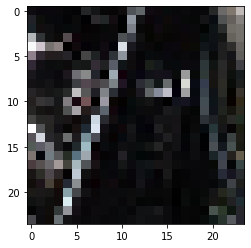

In [149]:
utils.plt_tensor(x[90])

tensor([[1.0000e+00, 2.1052e-19]], device='cuda:0', grad_fn=<SoftmaxBackward>)

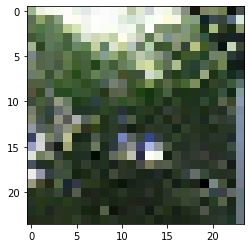

In [96]:
i = 12
utils.plt_tensor(x[i])
a = x[[i], :, :, :].to(device)
Net24(a)

In [97]:
len(dl)

39

In [99]:
39 * 256

9984

In [102]:
len(dl_test.dataset)

39016